## Import all requirements and dependencies

In [1]:
# Install all requirements

!pip install "numpy<=2.1.0"
!pip install seaborn
!pip install emoji
!pip install nltk
!pip install matplotlib
!pip install sentence-transformers scikit-learn pandas
!pip install UpSetPlot
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 24.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for UpSetPlot: filename=upsetplot-0.9.0-py3-none-any.whl size=24866 sha256=e17b43c2a2d01ebdc0a79726fc294db4fe163fc796537850e993b6e4e7c6531e
  Stored in directory: /root/.cache/pip/wheels/5d/7a/54/1460364da0fe4e17c256b7a28191fa373d81292fcf73a4ddb8
Successfully built UpSetPlot


In [2]:
# Import all modules

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import re
import emoji
from emoji import demojize
from pprint import pprint

import nltk
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np
from datetime import datetime
from huggingface_hub import snapshot_download

import matplotlib.pyplot as plt
import warnings

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Data preprocessing example

### Data preprocessing utils

In [3]:
# @title
def remove_if_only_emoji(text):
    if all(char in emoji.EMOJI_DATA for char in text.strip()):
        return ""
    return text

def clean_texts(text):
    """
    Preprocess a Reddit text by:
    1. Splitting by sentences.
    2. Replacing emojis with corresponding text.
    3. Removing extra spaces and hyperlinks.
    4. Removing text in square brackets.
    5. Replacing '|' with ','.
    6. Deduplicating '*' and replacing it with '.'.

    Args:
        text (str): The original Reddit text content.

    Returns:
        list: A list of cleaned sentences.
    """
    text = remove_if_only_emoji(text)
    if not text:
      return text

    # 2. Replace emojis with corresponding text
    text = demojize(text)

    # 3. Replace special character
    text = re.sub(r'▲', 'increase', text)
    text = re.sub(r'▼', 'decrease', text)
    text = text.replace("\n", " ")

    # 4. Remove hyperlinks
    text = re.sub(r"https?://\S+", "", text)

    # 5. Remove text in square brackets
    text = re.sub(r"\s+", " ", re.sub(r"\[.*?\]", "", text)).strip()

    # 6. Replace '|' with ','
    text = text.replace('|', ',')

    # 7. Deduplicate '*' and replace it with '.'
    text = re.sub(r'\*+', '.', text)

    # 8. replace _ with space
    text = re.sub(r'_', ' ', text).strip()

    # 9. Remove date-like patterns
    text = re.sub(r'\b[A-Za-z]{3},\s\d{1,2}\s[A-Za-z]{3}\b', '', text)
    text = re.sub(r'\b[A-Za-z]+,\s\d{1,2}\s[A-Za-z]+\s—\s[\d,:]+\s[APM]+\s[A-Z]+\b', '', text)
    text = re.sub(r'\b[A-Za-z]+,\s\d{1,2}\s[A-Za-z]+\s—\s[\d,]{1,5}\s[APM]+\b', '', text)
    text = re.sub(r'\b\d{1,2}:\d{2}\s[A-Z]{3}\b', '', text)
    text = re.sub(r'\b\d{1,2}\s?[apAP]\.?[mM]\.?', '', text)


    # # 10. remove # or -
    text = re.sub(r'[#-]', ',', text)

    # 11. replace : with ,
    text = re.sub(r':', ' ', text)

    # 12. remove extra space
    text = re.sub(r'\s+', ' ', text).strip()

    # 13. remove () <> {}
    text = re.sub(r'[()<{}]', '', text)
    text = re.sub(r'>', '.', text)

    # 14. Remove extra commas and periods at the beginning
    text = re.sub(r'^[,.]+', '', text)

    text = re.sub(r'\s[^\w\s]\s', ' ', text)

    # 15. Remove duplicate punctation
    text = re.sub(r'\s[!?.,]+', ' ', text)

    # 16. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # 17. Remove all punctation
    text = re.sub(r'[^\w\s]', '', text)
    return text

### Data preprocessing example usage

In [4]:
# Example usage
example_comment = "Hello world! route\n\nhttps://preview.redd.it/vcig96ctlnbe1.jpeg?width=3024&format=pjpg&auto=webp&s=c66fb87369421455fb10b6f66e5d8ec83eaec033 Saturday, 29 June — 11,00 PM 😊 ## - - 17 p.m. - Check this:\nhttps://example.com [remove this] **Hello** | <>>{test} ▲ ▼ Goodbye, . (Fri, 28 Jun)"
#emoji_comment = "😊😊😊😊😊😊😊"
cleaned_data = clean_texts(example_comment)
print("Cleaned sentences:")
cleaned_data

Cleaned sentences:


'Hello world route smiling face with smiling eyes Check this Hello test increase decrease Goodbye'

### Download and load datasets

In [ ]:
import pandas as pd

# Download load comments datasets.
dataset_path = snapshot_download(
    repo_id="Dragmoon/2025CalifoniaWildfire",
    repo_type="dataset",
    local_dir="./datasets"
)

# Load datasets
posts_df = pd.read_csv(os.path.join(dataset_path, 'reddit/all_final_posts_multiple_label.csv'))
posts_df['Situational Awareness'] = posts_df['Situational Awareness'].str.split(',')
posts_df['Crisis Narrative'] = posts_df['Crisis Narrative'].str.split(',')

In [6]:
# Take non empty Crisis Narative posts
posts_cn = posts_df[posts_df['Crisis Narrative'].notna()]

In [7]:
# Load all comments
comments_df = pd.read_csv(os.path.join(dataset_path, 'reddit/all_final_comments_multiple_label.csv'))

# Convert the comma-separated string into a list of labels
comments_df['Situational Awareness'] = comments_df['Situational Awareness'].str.split(',')
comments_df['Crisis Narrative'] = comments_df['Crisis Narrative'].str.split(',')

In [8]:
# Take non empty Crisis Narative comments
comments_cn = comments_df[comments_df['Crisis Narrative'].notna()]

## Data visualization

### Visualization utils

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import from_memberships, UpSet

def generate_upset_plot(posts_df, comments_df, label_column='Situational Awareness', threshold=24, highlight_category=None):
    """
    Generate an UpSet plot combining two datasets.

    Parameters:
        posts_df (pd.DataFrame): DataFrame containing a column (specified by label_column) for posts.
                                 Each entry should be a list of labels.
        comments_df (pd.DataFrame): DataFrame with comments data that contains a column (specified by label_column)
                                    with comma-separated labels as a string and a 'Count' column.
        label_column (str): The name of the column that holds the membership labels.
        threshold (int): Only include membership combinations that have a total count greater than or equal to this value.
    """
    # Process posts_df: Create the upsetplot data for dataset 1 (each instance counts as 1).
    memberships1 = posts_df[label_column].tolist()
    data1 = from_memberships(memberships1, data=[1] * len(memberships1))
    # Group duplicates to ensure the multi-index is unique.
    data1 = data1.groupby(level=list(range(data1.index.nlevels))).sum()

    memberships2 = comments_df[label_column].tolist()
    data2 = from_memberships(memberships2, data=comments_df['Count'].tolist())
    # Group duplicates to ensure the multi-index is unique.
    data2 = data2.groupby(level=list(range(data2.index.nlevels))).sum()

    # Combine the two datasets.
    combined_data = data1.add(data2, fill_value=0)

    # Filter the combined data by the threshold count.
    filtered_data = combined_data[combined_data >= threshold]

    # Generate the UpSet plot from the combined data.
    upset = UpSet(filtered_data, show_counts=True, facecolor='#5D5D5D')

    if highlight_category:
        # Apply styling options for the category "Public health and safety".
        upset.style_categories("Public health and safety", shading_facecolor="lavender")
        upset.style_categories(["Public health and safety"], bar_facecolor="#4F8CCC")
        upset.style_subsets(present="Public health and safety", facecolor='#4F8CCC')

    plt.suptitle("Combined UpSet Plot", fontsize=14)
    upset.plot()
    plt.show()

# Suppress all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Visualize Situational Awareness

<Figure size 640x480 with 0 Axes>

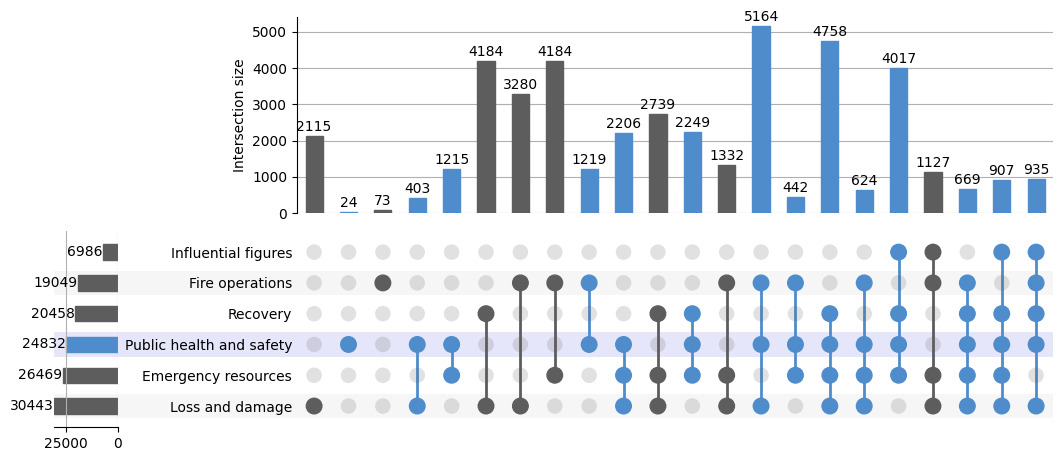

In [10]:
generate_upset_plot(posts_df, comments_df, label_column='Situational Awareness', threshold=24, highlight_category="Public health and safety")

### Visualize Crisis Narrative

<Figure size 640x480 with 0 Axes>

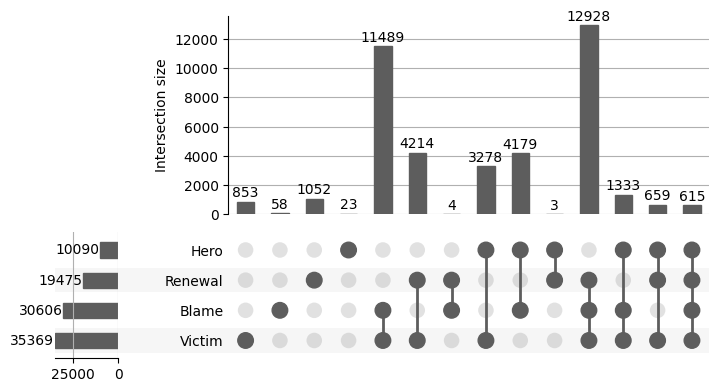

In [11]:
generate_upset_plot(posts_cn, comments_cn, label_column='Crisis Narrative', threshold=0)

### Load raw comment data

In [13]:
comments_df = pd.read_csv(os.path.join(dataset_path, 'reddit/all_raw_comments.csv'))
comments_df

,post_id,comment_id,author,body,score,created_utc
0,8eb4a7f25baa08ab,b7a0a265b0a28462,72d3ca82b6f74987,A lot of people put their Christmas trees out ...,68,2025-01-07 20:42:05
1,8eb4a7f25baa08ab,8442054266b04ba2,9822bf44dcd5e160,Just want to say I’m proud of our neighborhood...,44,2025-01-08 06:50:05
2,8eb4a7f25baa08ab,4232aa04196bfc38,3475e9939d215907,Hoping it won’t be as bad as the 2011 event.,29,2025-01-07 18:28:57
3,8eb4a7f25baa08ab,62edf12d514906a3,5126968ff96d0bcf,"Saw a tree that had fallen on a car, a down po...",26,2025-01-07 19:15:50
4,8eb4a7f25baa08ab,c6537cc1180dc4b8,0f8909a299ff486a,An Evacuation Shelter has been established at ...,25,2025-01-08 06:06:55
...,...,...,...,...,...,...
114874,fa0eeaf751cb7dd1,f67bb06566c6cde4,389cebf5ae5e2b9b,IT Solutions. Senior Management seemed mostly ...,2,2025-02-02 15:41:01
114875,fa0eeaf751cb7dd1,767dac95e2659a5f,8c33d1074065b5e4,Actual. You can research yourself by googling ...,-1,2025-02-03 01:45:36
114876,fa0eeaf751cb7dd1,d7376f40942cff34,2261c6afd19bc6c0,Thanks for the perspective. How is the CIO?,1,2025-02-02 15:42:53
114877,fa0eeaf751cb7dd1,f92cd6714bc4ab96,389cebf5ae5e2b9b,"Unsure, CIO was too high level to ever be pres...",3,2025-02-02 16:50:04


### Show sample comments (non deleted)

In [14]:
comments = comments_df[comments_df['body'] != '[deleted]']
comments.head(10)

,post_id,comment_id,author,body,score,created_utc
0,8eb4a7f25baa08ab,b7a0a265b0a28462,72d3ca82b6f74987,A lot of people put their Christmas trees out ...,68,2025-01-07 20:42:05
1,8eb4a7f25baa08ab,8442054266b04ba2,9822bf44dcd5e160,Just want to say I’m proud of our neighborhood...,44,2025-01-08 06:50:05
2,8eb4a7f25baa08ab,4232aa04196bfc38,3475e9939d215907,Hoping it won’t be as bad as the 2011 event.,29,2025-01-07 18:28:57
3,8eb4a7f25baa08ab,62edf12d514906a3,5126968ff96d0bcf,"Saw a tree that had fallen on a car, a down po...",26,2025-01-07 19:15:50
4,8eb4a7f25baa08ab,c6537cc1180dc4b8,0f8909a299ff486a,An Evacuation Shelter has been established at ...,25,2025-01-08 06:06:55
5,8eb4a7f25baa08ab,00f78f5f166f5322,a9dd6562f8e1005f,"Tree down blocking Lincoln Ave, north of Orang...",20,2025-01-07 23:10:18
6,8eb4a7f25baa08ab,050ff76108d9f83b,1500edce5feb036f,These firefighters are the real heroes,23,2025-01-08 03:48:00
7,8eb4a7f25baa08ab,d02f16937ae7e965,0f8909a299ff486a,Ok I have been updating for 4 hours Im talking...,20,2025-01-08 05:04:52
8,8eb4a7f25baa08ab,0d0c53e67989e69c,359713a082b61067,"Hey everyone, I have a sad update about the fi...",23,2025-01-08 10:43:03
9,8eb4a7f25baa08ab,7104e0c8b7291c93,508da67c080ee160,No one is planning on going to work in the mor...,20,2025-01-08 11:42:34


### Show sample comments with length is exactly 10 words

In [15]:
from nltk.tokenize import word_tokenize
# Function to preprocess a document
def preprocess_document(doc):
    if doc is None:
        return None  # or return an empty string '' if you prefer
    # Ensure the document is a string
    doc_str_raw = doc if isinstance(doc, str) else str(doc)
    doc_str = clean_texts(doc_str_raw)
    # Tokenize the document
    tokens = word_tokenize(doc_str.lower())  # Convert to lowercase and tokenize
    return ' '.join(tokens)  # Join tokens back into a string

# Preprocess comments
comments['corpus'] = comments['body'].apply(preprocess_document)

# Calculate the length of each cell in the 'processed_content' column and store it in a new column
comments['corpus_length'] = comments['corpus'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

/tmp/ipython-input-1177037682.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments['corpus'] = comments['body'].apply(preprocess_document)
/tmp/ipython-input-1177037682.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments['corpus_length'] = comments['corpus'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)


In [16]:
# Show sample comments with length >= 10.
i = 0
for sen in comments[comments['corpus_length'] == 10]['corpus'][:10]:
    i += 1
    print( str(i) + ' ' + sen + '\n')

1 hoping it wont be as bad as the 2011 event

2 the wind gusts right now are insane must be 6070mph

3 am i imagining did pase018 go from evac to warning

4 im afraid to ask for news on mt wilson observatory

5 if you are in kinneloa mesa i would evacuate immediately

6 chances this fire gets as far south as san gabriel

7 heard theres a fire on calaveras near xmas tree lane

8 nbc 4 showing houses in mendocino near tanoble and allen

9 is there a stream no power over here for tvs

10 our gardeners came today while i was at work lol

